This project analyzes customer churn data to understand the key factors driving customer attrition and to build a predictive model. The goal is to identify patterns in customer behavior and train a machine learning model to classify whether a customer is likely to churn.

Tasks performed:
1. Data Cleaning and Preprocessing
2. Exploratory Data Analysis (EDA)
3. Feature Encoding and Scaling
4. Model Building and Evaluation
5. Model Deployment

Dataset source: Telco Customer Churn dataset from Kaggle.


In [ ]:
import kagglehub

path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /Users/matt/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


Data Loading and Cleaning

After loading the dataset we inspect its structure, null values, and data types. Necessary changes are implemented.


In [30]:
import pandas as pd

file_path = "/Users/matt/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Total Charges is an object but needs to be numeric
print(df.dtypes)


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [ ]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


In [ ]:
# After converting TotalCharges to Numeric Nan values are found
print(df.isnull().sum())


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [ ]:
# Check if tenure is 0 for TotalCharges=nan. If it is then NaN values are caused by tenure being 0 so we can assign TotalCharges=0 for these cases.
df[df['TotalCharges'].isna()][['tenure', 'TotalCharges']]


,tenure,TotalCharges
488,0,NaN
753,0,NaN
936,0,NaN
1082,0,NaN
1340,0,NaN
3331,0,NaN
3826,0,NaN
4380,0,NaN
5218,0,NaN
6670,0,NaN


In [ ]:
# Replace Nan with 0
df.loc[df['TotalCharges'].isna(), 'TotalCharges'] = 0


Exploratory Data Analysis (EDA)

Explore numerical and categorical features to understand data distributions and relationships with churn. 
1) KDE plots for numerical variables
2) Stacked bar plots for key categorical variables vs churn
3) Heatmaps for feature correlation (numeric and categorical)

<function matplotlib.pyplot.show(close=None, block=None)>

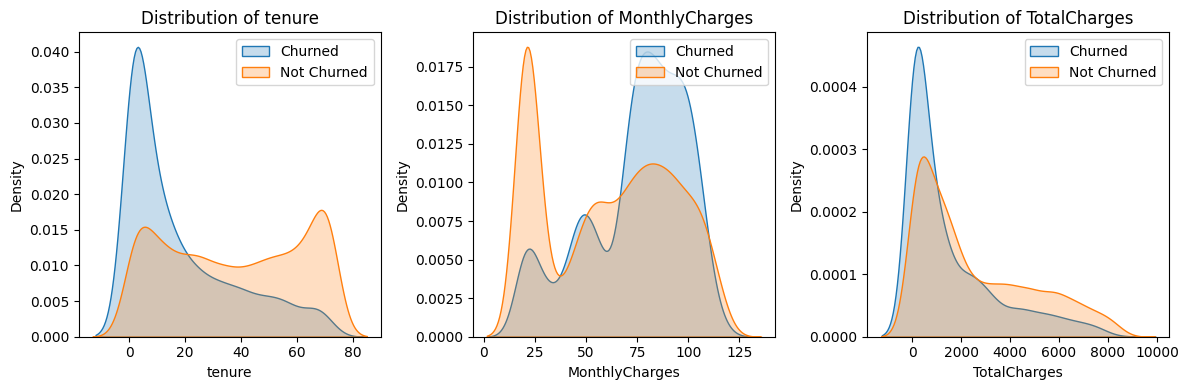

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Plot KDE 
plt.figure(figsize=(12, 4))
for i, feature in enumerate(numerical_features):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(df[df['Churn'] == 'Yes'][feature], label='Churned', fill=True)
    sns.kdeplot(df[df['Churn'] == 'No'][feature], label="Not Churned", fill=True)
    plt.title(f"Distribution of {feature}")
    plt.legend()

plt.tight_layout()
plt.show

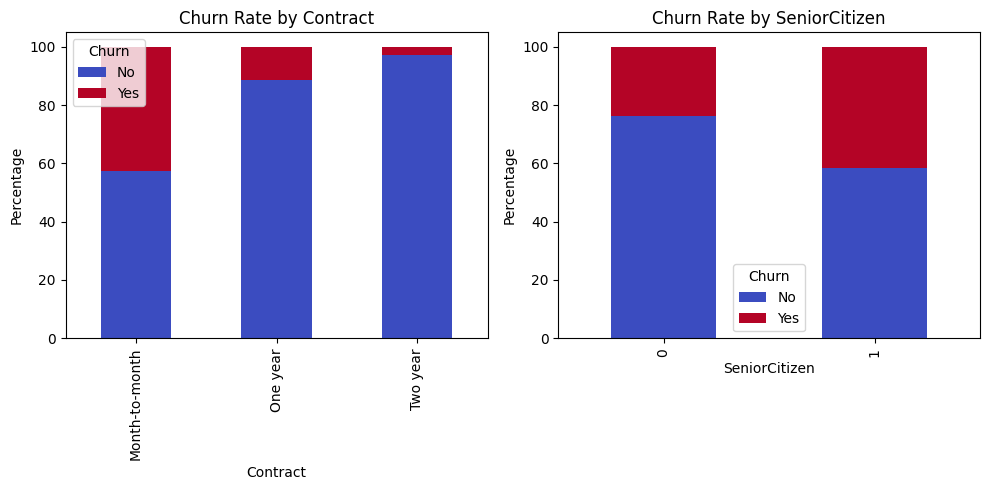

In [ ]:
# Bar chart to visualise Churn rate by categorical features (Contract type and SeniorCitizen).
categorical_features = ['Contract', 'SeniorCitizen']

plt.figure(figsize=(10,5))
for i, feature in enumerate(categorical_features):
    plt.subplot(1, 2, i+1)
    churn_counts = pd.crosstab(df[feature], df['Churn'], normalize='index') * 100
    churn_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='coolwarm')
    plt.title(f'Churn Rate by {feature}')
    plt.ylabel('Percentage')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()



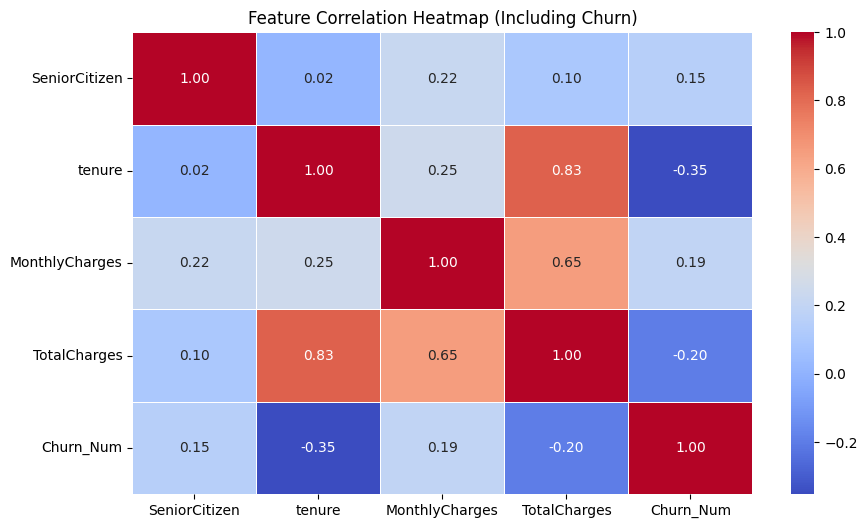

In [38]:
# Convert churn to numeric in a temporary df copy for Pearson correlation heatmap
df_temp = df.copy()
df_temp['Churn_Num'] = df_temp['Churn'].map({'No': 0, 'Yes': 1})  

# Compute correlation matrix
correlation_matrix = df_temp.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Heatmap (Including Churn)")
plt.show()


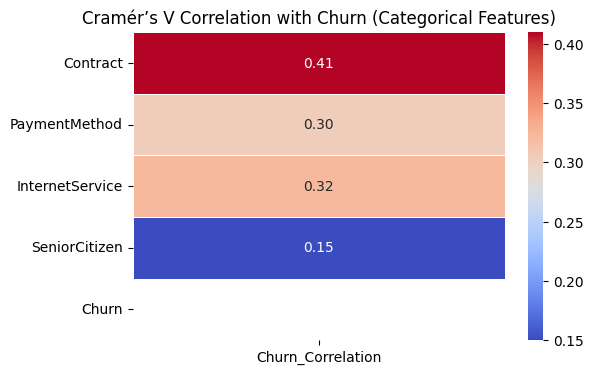

In [39]:
import numpy as np
import scipy.stats as ss

# Cramér's V function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Compute Cramér’s V for categorical features 
categorical_features = ['Contract', 'PaymentMethod', 'InternetService', 'SeniorCitizen', 'Churn']
correlation_matrix_cat = pd.DataFrame(index=categorical_features, columns=['Churn_Correlation'])

for feature in categorical_features:
    if feature != 'Churn':  
        correlation_matrix_cat.loc[feature, 'Churn_Correlation'] = cramers_v(df_temp[feature], df_temp['Churn'])

correlation_matrix_cat = correlation_matrix_cat.astype(float)

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix_cat, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Cramér’s V Correlation with Churn (Categorical Features)")
plt.show()


Logistic Regression Model
1) Define features and target (X, y) 
2) Preprocessing : Scale numerical columns, Encode categorical columns
3) Combine preprocessing and Logistic Regression in a Pipeline
4) Perform 5-fold cross validation to optimise hyperparameters and use 'balanced' class_weight to account for class imbalance 
5) Model Evaluation 

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

# Drop identifier column 
df_model = df.drop(columns=['customerID'])

# Separate Churn from features
X = df_model.drop(columns=['Churn'])
y = df_model['Churn'].map({'Yes': 1, 'No': 0})  

# Identify numerical and categorical columns for preprocessing
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply scaling and encoding to numerical and categorical features respectively
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)

# Create a pipeline to apply preprocessing and train a logistic regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Define hyperparameter grid for model tuning
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs']
}

# Use 5-fold cross validation to find the best model
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

# Select the best model from cross validation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Model evaluation
from sklearn.metrics import classification_report
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'classifier__C': 1, 'classifier__solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1036
           1       0.52      0.83      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



best_model performs well with churn recall which is the goal. Low churn precision is not as important since flagging a 'non-churner' as 'churner' does not amount in lost customers. Similarly higher churn recall means the model predicts more of the actual churners and action can be taken by the company to retain those customers.

Proceed to predict churn probabilities for every customer so action can be taken based on each customers churn risk. 
Plot predicted vs actual churn for different probability ranges.

In [ ]:
# Get churn probabilities for every customer
churn_probs = best_model.predict_proba(X)[:, 1]

# Convert to DataFrame with customer IDs
churn_results = pd.DataFrame({
    'customerID': df['customerID'] , 
    'Churn_Probability': churn_probs
})

# Sort by highest churn risk
churn_results = churn_results.sort_values(by='Churn_Probability', ascending=False)

high_risk_customers = churn_results[churn_results['Churn_Probability'] > 0.5]
print(high_risk_customers)  


      customerID  Churn_Probability
3380  5178-LMXOP           0.930835
1410  7024-OHCCK           0.930071
1976  9497-QCMMS           0.929625
4800  9300-AGZNL           0.929295
2208  7216-EWTRS           0.928461
...          ...                ...
4534  2607-FBDFF           0.501395
5385  0843-WTBXE           0.501181
2754  6351-SCJKT           0.500074
89    3016-KSVCP           0.500059
6028  1871-MOWRM           0.500014

[2949 rows x 2 columns]


In [42]:
#Check how many customers from each probability range actually churned.

bins = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ["50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]

churn_results["Churn_Probability_Range"] = pd.cut(
    churn_results["Churn_Probability"], bins=bins, labels=labels
)

churn_results = churn_results.merge(df[['customerID', 'Churn']], on="customerID", how="left")

if 'Churn_x' in churn_results.columns and 'Churn_y' in churn_results.columns:
    churn_results.drop(columns=['Churn_x'], inplace=True)
    churn_results.rename(columns={'Churn_y': 'Churn'}, inplace=True)

if churn_results['Churn'].dtype == 'object':
    churn_results['Churn'] = churn_results['Churn'].map({'Yes': 1, 'No': 0})
else:
    churn_results['Churn'] = churn_results['Churn'].astype(int)  

total_per_range = churn_results.groupby("Churn_Probability_Range")["customerID"].count()

actual_churned_per_range = churn_results.groupby("Churn_Probability_Range")["Churn"].sum()

comparison_df = pd.DataFrame({
    "Total Customers": total_per_range,
    "Actual Churned": actual_churned_per_range
}).reset_index()

print(comparison_df)


  Churn_Probability_Range  Total Customers  Actual Churned
0                  50-60%              576             175
1                  60-70%              610             218
2                  70-80%              770             397
3                  80-90%              911             653
4                 90-100%               82              70


/var/folders/0m/jrmwp1pd3cxflrwbtn7fyyt80000gn/T/ipykernel_21890/1720005067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_range = churn_results.groupby("Churn_Probability_Range")["customerID"].count()
/var/folders/0m/jrmwp1pd3cxflrwbtn7fyyt80000gn/T/ipykernel_21890/1720005067.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  actual_churned_per_range = churn_results.groupby("Churn_Probability_Range")["Churn"].sum()


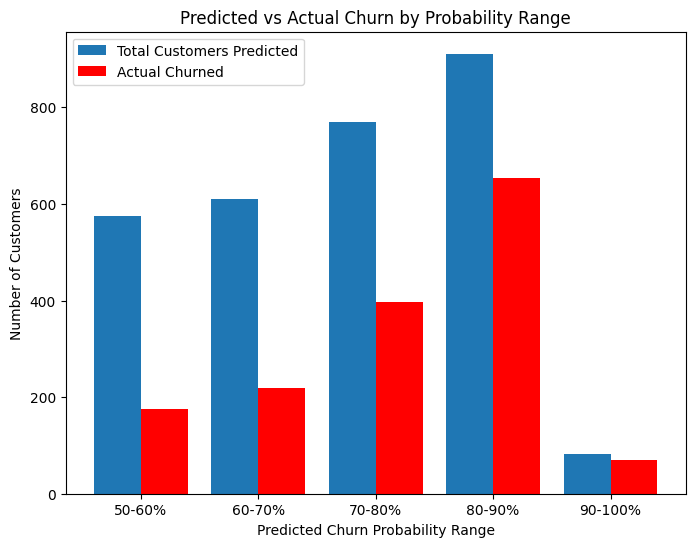

In [46]:
plt.figure(figsize=(8,6))
bar_width = 0.4
x = np.arange(len(comparison_df))

plt.bar(x - bar_width/2, comparison_df["Total Customers"], bar_width, label="Total Customers Predicted")
plt.bar(x + bar_width/2, comparison_df["Actual Churned"], bar_width, label="Actual Churned", color="red")

plt.xlabel("Predicted Churn Probability Range")
plt.ylabel("Number of Customers")
plt.title("Predicted vs Actual Churn by Probability Range")
plt.xticks(ticks=x, labels=comparison_df["Churn_Probability_Range"])
plt.legend()
plt.show()


Feature importance with SHAP  

SHAP is used to interpret the model's predictions and identify the most influential features contributing to churn.


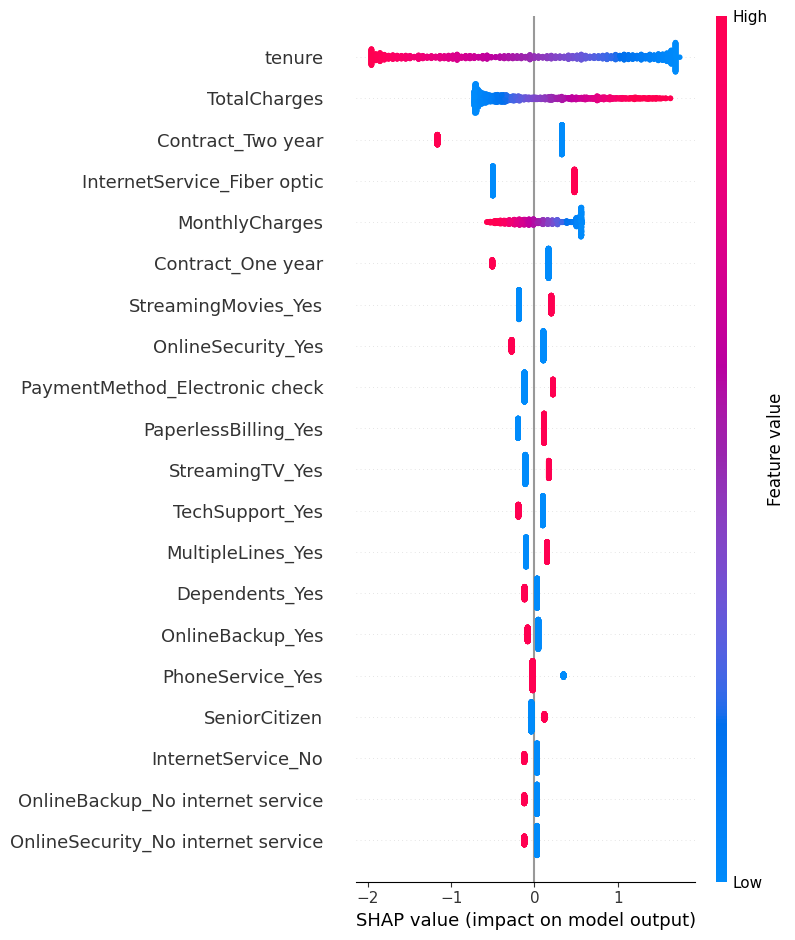

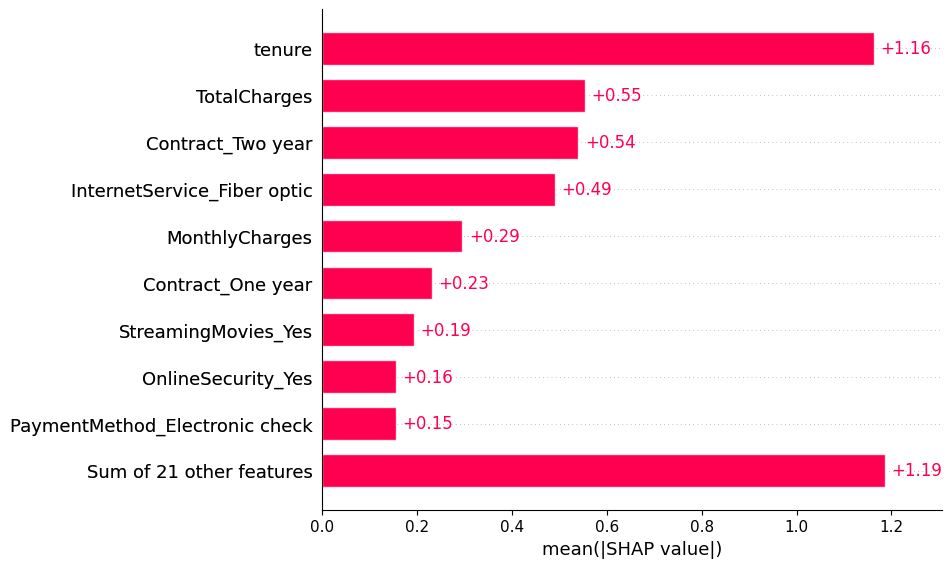

In [44]:
import shap

# Transform test data and get feature names
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = (
    list(best_model.named_steps['preprocessor'].transformers_[0][2]) +  
    list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
)

# Wrap transformed data in DataFrame 
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Run SHAP on best_model
explainer = shap.Explainer(best_model.named_steps['classifier'], X_test_df)
shap_values = explainer(X_test_df)

# Plot
shap.summary_plot(shap_values, X_test_df)
shap.plots.bar(shap_values)



Model Deployment 

The trained pipeline model is saved using `joblib`, making it ready for deployment.  
Because preprocessing is included in the pipeline, it can receive raw customer input and output churn predictions directly with no extra transformations.  

This model will be deployed on Azure for end-user interaction.


In [ ]:
import joblib

# Save the entire pipeline (preprocessing + model)
joblib.dump(best_model, 'churn_model_pipeline.pkl')

Model saved as churn_model_pipeline.pkl
